- Récupération du code source après connexion

In [1]:
import pandas as pd

# Charger le fichier Excel
df = pd.read_excel("Projets.xlsx", sheet_name="Anciens")

# Trier par ID croissant
df = df.sort_values(by='id')

# Afficher la liste des colonnes
print(df.columns)

Index(['id', 'url', 'Ouverture', 'nom', 'extraction', 'Statut', 'Prix minimum',
       'Département', 'Entreprise', 'Collecte', 'Maximum', 'Progression',
       'Clôture_prog', 'Année de clôture', 'Type', 'Type d'opération',
       'Coût total opération', 'Marge prévisionnelle totale', 'Taux annuel',
       'Durée de paiement (en mois)', 'Investisseurs', 'Image'],
      dtype='object')


Nettoyage des donnée

In [2]:
import pandas as pd

# --- Fonction pour convertir 'Clôture_prog' ---
def convertir_cloture(valeur):
    if pd.isna(valeur):
        return pd.NaT
    valeur = str(valeur).lower().strip()

    mois_map = {
        "janvier": 1, "février": 2, "fevrier": 2, "mars": 3,
        "avril": 4, "mai": 5, "juin": 6, "juillet": 7,
        "août": 8, "aout": 8, "septembre": 9,
        "octobre": 10, "novembre": 11, "décembre": 12, "decembre": 12
    }

    saisons = {
        "printemps": (3, 20),
        "été": (6, 21), "ete": (6, 21),
        "automne": (9, 23),
        "hiver": (12, 21)
    }

    mots = valeur.split()

    if len(mots) == 2 and mots[1].isdigit():
        an = int(mots[1])
        if mots[0] in ["fin"]:
            return pd.Timestamp(an, 12, 31)
        elif mots[0] in ["début", "debut"]:
            return pd.Timestamp(an, 1, 1)
        elif mots[0] in saisons:
            mois, jour = saisons[mots[0]]
            return pd.Timestamp(an, mois, jour)
        elif mots[0] in mois_map:
            mois = mois_map[mots[0]]
            return pd.Timestamp(an, mois, 1)
    return pd.NaT

# --- Conversion des colonnes ---
df["id"] = pd.to_numeric(df["id"], errors="coerce")
df["Investisseurs"] = pd.to_numeric(df["Investisseurs"], errors="coerce").astype("Int64")
df["Durée de paiement (en mois)"] = pd.to_numeric(df["Durée de paiement (en mois)"], errors="coerce").astype("Int64")
df["Année de clôture"] = pd.to_numeric(df["Année de clôture"], errors="coerce").astype("Int64")
df["Département"] = df["Département"].astype("Int64").astype("category")

# Colonnes de type 'category'
colonnes_categorique = ['url', 'nom', 'extraction', 'Statut', 'Entreprise', 'Type', 'Type d\'opération', 'Image']
for col in colonnes_categorique:
    df[col] = df[col].astype("category")

# Conversion en datetime
df["Ouverture"] = pd.to_datetime(df["Ouverture"], errors="coerce")
df["Clôture_prog"] = df["Clôture_prog"].apply(convertir_cloture)


# Vérification finale
print(df.dtypes)
print(df.head())

id                                      int64
url                                  category
Ouverture                      datetime64[ns]
nom                                  category
extraction                           category
Statut                               category
Prix minimum                          float64
Département                          category
Entreprise                           category
Collecte                              float64
Maximum                               float64
Progression                           float64
Clôture_prog                   datetime64[ns]
Année de clôture                        Int64
Type                                 category
Type d'opération                     category
Coût total opération                  float64
Marge prévisionnelle totale           float64
Taux annuel                           float64
Durée de paiement (en mois)             Int64
Investisseurs                           Int64
Image                             

Analyse de statut

In [3]:
# Compter les occurrences de chaque statut
statut_counts = df['Statut'].value_counts(dropna=False)

# Afficher les résultats
print("Nombre de projets par statut :")
print(statut_counts)

Nombre de projets par statut :
Statut
Financé      348
Remboursé    205
NaN           23
Echec          7
Name: count, dtype: int64


In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Copie du DataFrame
df_encoded = df.copy()

# Encodage de toutes les colonnes object et category avec gestion des NaN
for col in df_encoded.select_dtypes(include=['object', 'category']):
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str).fillna('missing'))

# Encodage de la variable cible 'Statut'
statut_encoded = LabelEncoder().fit_transform(df_encoded["Statut"].astype(str).fillna('missing'))

# Calcul des corrélations avec 'Statut'
correlations = df_encoded.select_dtypes(include='number').corrwith(pd.Series(statut_encoded, name='Statut'))

# Affichage trié par corrélation absolue décroissante
print("Corrélations (fortes positives ou négatives) avec Statut :")
print(correlations.reindex(correlations.abs().sort_values(ascending=False).index))

Corrélations (fortes positives ou négatives) avec Statut :
Type                          -0.435127
Entreprise                    -0.193284
Image                          0.178927
url                            0.176714
id                             0.136925
Progression                   -0.121945
nom                            0.074023
Durée de paiement (en mois)   -0.049972
Taux annuel                    0.046290
Maximum                       -0.031659
Investisseurs                 -0.023576
Prix minimum                  -0.015750
Collecte                       0.004581
Département                   -0.000871
Statut                        -0.000595
extraction                          NaN
Année de clôture                    NaN
Type d'opération                    NaN
Coût total opération                NaN
Marge prévisionnelle totale         NaN
dtype: float64


c:\Users\CYTech Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\CYTech Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\CYTech Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\CYTech Student\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Preprocessing + Modèle

In [ ]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
pipeline_bayes.py – build & explain XGBoost model
Version 2024-07 • optimisation bayésienne Optuna (+ joli progress-bar)
"""

from __future__ import annotations
# ───────────────────── Imports ──────────────────────
import warnings, pathlib, pickle, joblib, inspect
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, accuracy_score)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
import optuna
from optuna.distributions import IntDistribution, FloatDistribution
from tqdm.auto import tqdm                               # progress-bar
from optuna.integration import OptunaSearchCV   # ← à mettre juste après tes autres imports Optuna
warnings.filterwarnings("ignore", category=UserWarning)

# ─────────── réglages généraux ────────────
RND, TARGET_COL = 42, "Statut"
DROP_COLS = ["id","url","extraction","Image","nom","Progression","Maximum"]
DATE_COLS, RARE_THRESH = ("Ouverture","Clôture_prog"), 5
EXCEL_PATH, SHEET_NAME = pathlib.Path("Projets.xlsx"), "Anciens"

# --- dossiers de sortie -------------------------------------------------
OUT_DIR = pathlib.Path("outputs"); OUT_DIR.mkdir(exist_ok=True)
IMG_DIR = OUT_DIR / "images";     IMG_DIR.mkdir(exist_ok=True)

# --- chemins PNG --------------------------------------------------------
IMG_CM   = IMG_DIR / "confusion_matrix.png"
IMG_IMP  = IMG_DIR / "top15_features.png"
IMG_KPI  = IMG_DIR / "accuracy_kpi.png"
IMG_PER  = IMG_DIR / "accuracy_par_classe.png"
IMG_TREE = IMG_DIR / "arbre_decision_simplifie.png"
IMG_LC   = IMG_DIR / "xgb_learning_curve.png"

# --- fichiers pickle ----------------------------------------------------
PREPROC_PKL = OUT_DIR / "preprocess.pkl"
MODEL_PKL   = OUT_DIR / "xgb_model.pkl"
LABELS_PKL  = OUT_DIR / "labels.pkl"

# ───────── 1. Transformer DataPrep ─────────
class DataPrep(BaseEstimator, TransformerMixin):
    """nettoyage + encodage catégoriel pandas (inclut Département)."""
    def __init__(self, drop_cols:list[str], date_cols:tuple[str,...],
                 rare_thresh:int, target_col:str):
        self.drop_cols, self.date_cols, self.rare_thresh = drop_cols, date_cols, rare_thresh
        self.target_col = target_col

    def fit(self, X:pd.DataFrame, y=None):
        df = X.drop(columns=[c for c in self.drop_cols if c in X], errors="ignore").copy()
        for c in self.date_cols:
            if c in df: df[c] = pd.to_datetime(df[c], errors="coerce").dt.year.astype("Int64")
        if "Département" in df:
            df["Département"] = df["Département"].astype(str).str.zfill(2)

        self.num_cols_  = df.select_dtypes(include=["number","Int64"]).columns.tolist()
        self.num_means_ = df[self.num_cols_].mean()

        self.cat_cols_    = [c for c in df.columns if c not in self.num_cols_+[self.target_col]]
        self.rare_levels_, self.categories_ = {},{}
        for c in self.cat_cols_:
            s   = df[c].astype(str)
            rare = s.value_counts()[lambda v: v< self.rare_thresh].index
            self.rare_levels_[c] = set(rare)
            self.categories_[c]  = sorted(set(s)-set(rare))+["RARE","NA"]
        return self

    def transform(self, X:pd.DataFrame)->pd.DataFrame:
        df = X.drop(columns=[self.target_col], errors="ignore").copy()
        df = df.drop(columns=[c for c in self.drop_cols if c in df], errors="ignore")
        for c in self.date_cols:
            if c in df: df[c] = pd.to_datetime(df[c], errors="coerce").dt.year.astype("Int64")
        if "Département" in df:
            df["Département"] = df["Département"].astype(str).str.zfill(2)
        for col in self.num_cols_:
            df[col] = df.get(col, pd.Series(np.nan,index=df.index)).fillna(self.num_means_[col])
        for c in self.cat_cols_:
            s = df.get(c, pd.Series("NA",index=df.index)).astype(str)
            s = s.where(~s.isna(),"NA").where(~s.isin(self.rare_levels_[c]),"RARE")
            s = s.where(s.isin(self.categories_[c]),"RARE")
            df[c] = pd.Categorical(s, categories=self.categories_[c]).codes.astype("int32")
        return df[self.num_cols_+self.cat_cols_]

# ───────── 2. Données & split ─────────
df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME).dropna(subset=[TARGET_COL])
y  = df[TARGET_COL]
X_tr_raw,X_te_raw,y_tr,y_te = train_test_split(
    df.drop(columns=[TARGET_COL]), y, test_size=.20, stratify=y, random_state=RND)

prep = DataPrep(DROP_COLS,DATE_COLS,RARE_THRESH,TARGET_COL).fit(X_tr_raw)
X_tr,X_te = prep.transform(X_tr_raw), prep.transform(X_te_raw)

le = LabelEncoder().fit(y)
y_tr_enc,y_te_enc = le.transform(y_tr), le.transform(y_te)

# ───────── 3. Optuna + progress-bar ─────────
base = XGBClassifier(
    objective="multi:softprob", eval_metric="mlogloss",
    enable_categorical=True, tree_method="hist", n_jobs=-1, random_state=RND
)

param_space = {
    "n_estimators":     IntDistribution(400,1200,step=100),
    "learning_rate":    FloatDistribution(0.015,0.07,log=True),
    "max_depth":        IntDistribution(3,6),
    "min_child_weight": IntDistribution(1,6),
    "gamma":            FloatDistribution(0.0,1.0),
    "subsample":        FloatDistribution(0.6,1.0),
    "colsample_bytree": FloatDistribution(0.6,1.0),
    "reg_lambda":       FloatDistribution(0.0,10.0),
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RND)

n_trials = 60
pbar     = tqdm(total=n_trials, bar_format="⏳ |{bar}| {percentage:3.0f}%")

def _tqdm_callback(study:optuna.study.Study, trial:optuna.trial.FrozenTrial):
    pbar.update(1)

search = OptunaSearchCV(
    estimator=base,
    param_distributions=param_space,
    n_trials=n_trials,
    scoring="f1_macro",
    cv=cv,
    random_state=RND,
    n_jobs=-1,
    refit=True,
    callbacks=[_tqdm_callback],        # <- maj barre
)

fit_kw = {"eval_set":[(X_te,y_te_enc)],
          "early_stopping_rounds":50,
          "verbose":False} if "early_stopping_rounds" in inspect.signature(base.fit).parameters else {}
print("🔍 Bayesian optimisation en cours…")
search.fit(X_tr, y_tr_enc, **fit_kw)
pbar.close()

model = search.best_estimator_
print("✅ Best params :", search.best_params_)


# ─────────────── 4. Visuels & KPI ────────────────────
preds_te = model.predict(X_te)
acc = accuracy_score(y_te_enc, preds_te)
print(f"🔬 Accuracy hold-out : {acc*100:.2f} %")

# 4a. Matrice de confusion
ConfusionMatrixDisplay.from_predictions(
    y_te_enc, preds_te, display_labels=le.classes_, cmap="Blues")
plt.tight_layout(); plt.savefig(IMG_CM, dpi=300); plt.close()

# 4b. Importances (gain)
imp = (pd.Series(model.get_booster().get_score(importance_type="gain"))
       .reindex(model.get_booster().feature_names, fill_value=0)
       .nlargest(15).sort_values())
imp.plot.barh(figsize=(8,5)); plt.title("Top 15 features – Gain"); plt.xlabel("Gain")
plt.tight_layout(); plt.savefig(IMG_IMP, dpi=300); plt.close()

# 4c. KPI widget
plt.figure(figsize=(4,2)); plt.gca().axis("off"); plt.gcf().set_facecolor("#2ecc71")
plt.text(0.5,0.5,f"{acc*100:.2f} %",ha="center",va="center",fontsize=34,color="white",fontweight="bold")
plt.tight_layout(); plt.savefig(IMG_KPI, dpi=300); plt.close()

# 4d. Accuracy par classe
cm = confusion_matrix(y_te_enc, preds_te)
(pd.Series(cm.diagonal()/cm.sum(axis=1), index=le.classes_)
   .sort_values().plot.barh(figsize=(8,5)))
plt.xlim(0,1); plt.xlabel("Accuracy"); plt.tight_layout(); plt.savefig(IMG_PER, dpi=300); plt.close()

# ─── 4f. Learning curve ──────────────────────────────────────────────
from sklearn.model_selection import learning_curve

# 1) Calcul des courbes (train / valid accuracy)
train_sizes, tr_scores, te_scores = learning_curve(
    estimator=model,
    X=X_all,
    y=le.transform(y),
    cv=cv,                                  # même schéma CV que l’optimisation
    train_sizes=np.linspace(0.30, 1.00, 7), # 30 % → 100 %, 7 paliers
    scoring="accuracy",
    n_jobs=-1,
    shuffle=True, random_state=RND          # pour des batches plus homogènes
)

# 2) Agrégation et filtrage (évite les NaN qui « cassent » les lignes)
tr_mean, tr_std = tr_scores.mean(1), tr_scores.std(1)
te_mean, te_std = te_scores.mean(1), te_scores.std(1)

valid_mask      = ~np.isnan(te_mean)       # garde uniquement les points complets
train_sizes     = train_sizes[valid_mask]
tr_mean, tr_std = tr_mean[valid_mask], tr_std[valid_mask]
te_mean, te_std = te_mean[valid_mask], te_std[valid_mask]

# 3) Plot
plt.figure(figsize=(10, 6))

plt.plot(train_sizes, tr_mean, marker="o", linestyle="-", label="Train")
plt.plot(train_sizes, te_mean, marker="s", linestyle="-", label="Valid")

plt.fill_between(train_sizes, tr_mean - tr_std, tr_mean + tr_std, alpha=0.15)
plt.fill_between(train_sizes, te_mean - te_std, te_mean + te_std, alpha=0.15)

plt.title("Learning curve – XGB")
plt.xlabel("Taille d'entraînement")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig(IMG_LC, dpi=300)
plt.close()

print("✅ Visuels enregistrés dans :", IMG_DIR.resolve())

# ─────────────── 5. Sauvegarde artefacts ────────────
joblib.dump(prep,  PREPROC_PKL)
joblib.dump(model, MODEL_PKL)
with open(LABELS_PKL, "wb") as f:
    pickle.dump(le.classes_.tolist(), f)

print("✅ preprocess.pkl :", PREPROC_PKL.resolve())
print("✅ xgb_model.pkl  :", MODEL_PKL.resolve())
print("✅ labels.pkl     :", LABELS_PKL.resolve())

⏳ |          |   0%

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_5112\2803678924.py:127: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  search = OptunaSearchCV(
[I 2025-07-12 23:16:38,435] A new study created in memory with name: no-name-6c30af29-1ac5-46ce-b53c-ddb912f9210e


🔍 Bayesian optimisation en cours…


[I 2025-07-12 23:16:50,597] Trial 5 finished with value: 0.7674585762105377 and parameters: {'n_estimators': 400, 'learning_rate': 0.034078579927577936, 'max_depth': 4, 'min_child_weight': 2, 'gamma': 0.4338715902823065, 'subsample': 0.9033385644176128, 'colsample_bytree': 0.7710754279298391, 'reg_lambda': 2.177603810125166}. Best is trial 5 with value: 0.7674585762105377.
[I 2025-07-12 23:16:51,161] Trial 4 finished with value: 0.7076581135786596 and parameters: {'n_estimators': 400, 'learning_rate': 0.01891052418799135, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 0.6758586211304443, 'subsample': 0.903949948795953, 'colsample_bytree': 0.9071928429863493, 'reg_lambda': 3.856390921821541}. Best is trial 5 with value: 0.7674585762105377.
[I 2025-07-12 23:16:52,167] Trial 1 finished with value: 0.6039152015847989 and parameters: {'n_estimators': 400, 'learning_rate': 0.06480513503066394, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 0.40026156866137874, 'subsample': 0.61253724123651

- samples : nombre total d’observations (lignes) présentes dans ce nœud.
- value : nombre de projets par classe cible (ici : Statut) dans ce nœud.
- gini :  mesure de l’impureté des classes dans ce nœud.
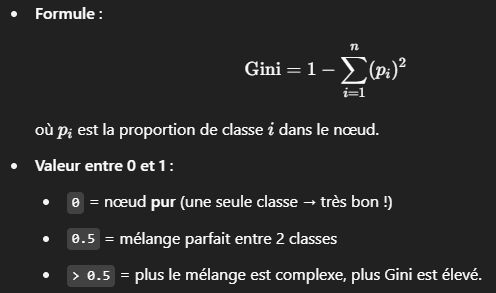

cd /d "H:\Desktop\Projet LPB\3 - API Scoring - Python Streamlit"
streamlit run app.py

In [ ]:
# Dans une cellule Jupyter
!streamlit run "H:/Desktop/Projet LPB/3 - API Scoring - Python Streamlit/app.py"